<a href="https://colab.research.google.com/github/alexberlaga/adjoint_matching/blob/main/Adjoint_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adjoint Matching Tutorial

## Introduction
Adjoint Matching is a novel algorithm designed for fine-tuning flow and diffusion generative models using stochastic optimal control (SOC). This tutorial provides a step-by-step guide to implementing Adjoint Matching and running experiments in Google Colab.

## Prerequisites
Before starting, ensure that you have Python installed with the following libraries:


In [ ]:
!pip install torch numpy matplotlib tqdm

## Step 1: Importing Dependencies
We first import necessary dependencies for building and training our model. These include `torch` for tensor operations, `numpy` for numerical operations, `matplotlib` for visualization, and `tqdm` for tracking progress. We also import `copy.deepcopy` for creating independent copies of models.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D

## Step 2: Sampling from a Gaussian Mixture
Define a function to generate samples from a Gaussian mixture distribution. We sample from a Gaussian mixture distribution because it serves as the target distribution for our flow matching process. By training on a mixture of Gaussians, our model learns to map simple Gaussian noise into a more complex distribution with multiple modes. This is essential for tasks where the underlying data distribution is multimodal.

In [ ]:
def gaussian_mixture_sample(batch_size, num_coords, x1, x2):
    component = torch.randint(0, 2, (batch_size,)).repeat(num_coords, 1)
    mean = torch.where(component.T == 0, x1, x2)
    return mean + torch.randn(batch_size, num_coords)

## Step 3: Define the Vector Field Model
The Vector Field model represents the continuous-time velocity field that guides samples from a simple distribution to a more complex one. It is implemented as a small neural network that takes input coordinates and time as features and outputs velocity values. The use of `ReLU` activation functions ensures non-linearity in learning transformations.

In [ ]:
class VectorField(nn.Module):
    def __init__(self, n_coords):
        self.n_coords = n_coords
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(self.n_coords + 1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, self.n_coords)
        )

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

## Step 4: Training the flow matching model

In this step, we train the vector field model using flow matching. The goal is to learn a transformation that progressively shifts samples from an initial Gaussian distribution toward our target Gaussian mixture. The loss function is a simple squared error between the predicted and target velocities. Training is done using the Adam optimizer, which adapts learning rates for efficient convergence.

In [ ]:
NUM_STEPS = 100
def train_flow_matching(num_steps=NUM_STEPS, n_coords=1, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VectorField(n_coords).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    losses = []
    for step in tqdm(range(num_steps), desc="Training Progress"):
        x0 = torch.randn(batch_size, n_coords).to(device)
        x1 = gaussian_mixture_sample(batch_size, n_coords, x1=torch.Tensor([-1.5, -1.5]), x2=torch.Tensor([1.5, 1.5])).view(-1, n_coords).to(device)
        t = torch.rand(batch_size, 1).to(device)
        xt = (1 - t) * x0 + t * x1
        v_target = x1 - x0
        v_pred = model(xt, t)
        loss = ((v_pred - v_target) ** 2).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return model, losses

model_base, losses_base = train_flow_matching(500, 2)

Training Progress: 100%|██████████| 500/500 [00:00<00:00, 731.64it/s]


### Visualize your results
The first plot will be your samples generated from your flow matching, while the second set of plots will show your intital $\mathcal{N}(0, I)$ distribution and your target Gaussian mixture.

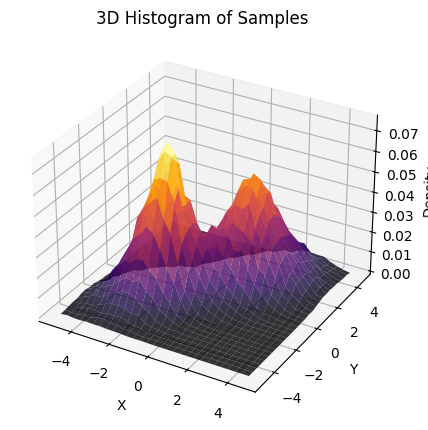

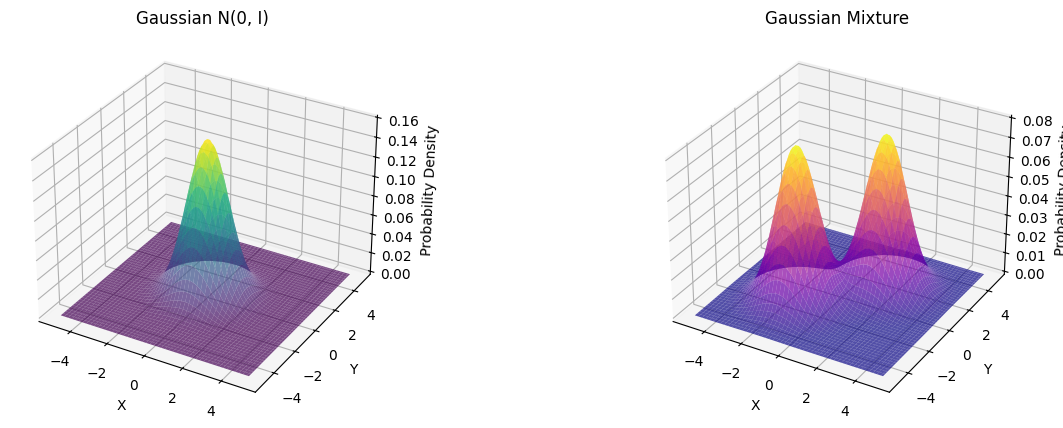

In [ ]:
def gaussian_pdf(X, mean, cov):
    d = X.shape[-1]
    det_cov = np.linalg.det(cov)
    norm_const = 1.0 / (np.sqrt((2 * np.pi) ** d * det_cov))
    exp_component = -0.5 * np.sum((X - mean) @ np.linalg.inv(cov) * (X - mean), axis=-1)
    return norm_const * np.exp(exp_component)

def sample_from_flow(model, num_samples=5000, num_coords=1, num_steps=NUM_STEPS, traj=False):
    """Simulate flow dynamics to generate samples."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    x = torch.randn(num_samples, num_coords).to(device)
    dt = 1.0 / num_steps
    trajec = torch.zeros((num_samples, num_steps, num_coords))
    for i in range(num_steps):
        t = torch.full((num_samples,), i / num_steps, device=device).view(-1, 1)
        v = model(x, t)
        x = x + v * dt  # Euler integration
        if traj:
            trajec[:, i, :] = x

    if traj:
        return trajec.cpu().detach().numpy()
    return x.cpu().detach().numpy()


def plot_3d_distributions(include_reward=False):
    if include_reward:
        axis_numbers=[131, 132]
    else:
        axis_numbers=[121, 122]
    x_vals = np.linspace(-5, 5, 100)
    y_vals = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x_vals, y_vals)
    grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    mean1 = np.array([0, 0])
    cov1 = np.eye(2)
    pdf1 = gaussian_pdf(grid, mean1, cov1).reshape(100, 100)

    mean2a = np.array([-1.5, -1.5])
    mean2b = np.array([1.5, 1.5])
    cov2 = np.eye(2)
    pdf2a = gaussian_pdf(grid, mean2a, cov2).reshape(100, 100)
    pdf2b = gaussian_pdf(grid, mean2b, cov2).reshape(100, 100)
    pdf2 = 0.5 * (pdf2a + pdf2b)

    pdf3 = pdf2 * np.exp(np.sin(X))
    pdf3 /= np.trapz(np.trapz(pdf3, x_vals, axis=0), y_vals, axis=0)

    fig = plt.figure(figsize=(15, 5))

    ax1 = fig.add_subplot(axis_numbers[0], projection='3d')
    ax1.plot_surface(X, Y, pdf1, cmap='viridis', alpha=0.7)
    ax1.set_title('Gaussian N(0, I)')

    ax2 = fig.add_subplot(axis_numbers[1], projection='3d')
    ax2.plot_surface(X, Y, pdf2, cmap='plasma', alpha=0.7)
    ax2.set_title('Gaussian Mixture')

    axes = [ax1, ax2]

    if include_reward:
        ax3 = fig.add_subplot(133, projection='3d')
        ax3.plot_surface(X, Y, pdf3, cmap='inferno', alpha=0.7)
        ax3.set_title('Gaussian Mixture * $\exp(\sin(x_0))$')
        axes.append(ax3)


    for ax in axes:
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Probability Density')

    plt.show()


def plot_3d_histogram(samples, x_vals, y_vals):
    hist, x_edges, y_edges = np.histogram2d(samples[:, 0], samples[:, 1], bins=[x_vals, y_vals], density=True)
    X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, hist.T, cmap='inferno', alpha=0.8)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Density')
    ax.set_title('3D Histogram of Samples')
    plt.show()


def plot_final_distribution(model, num_samples=100000, include_reward=False):
    """Plot the intermediate learned distribution."""
    samples = sample_from_flow(model, num_samples=num_samples, num_coords=2)

    x_vals = np.linspace(-5, 5, 30)
    y_vals = np.linspace(-5, 5, 30)
    plot_3d_histogram(samples, x_vals, y_vals)
    plot_3d_distributions(include_reward)


plot_final_distribution(model_base)

## Step 5: Additional Functions for Adjoint Matching
To refine our generative model, we employ Adjoint Matching. This involves simulating trajectories, computing adjoint states, and minimizing an adjoint-matching loss.

Minimizing the Adjoint Matching loss ensures that our fine-tuned generative model correctly follows the optimal control process needed to reach the tilted distribution. Here's the intuition in a step-by-step way:

We want our model to generate samples from the tilted distribution:
$p^*(x) \propto p_{\text{base}}(x)\exp(r(x))$ where $r(x)$ is some reward function that allows us to favor samples that we like.

This means modifying our Flow Matching model so that it naturally prefers high-reward samples while still staying close to the original model. The original Flow Matching model follows a simple deterministic transport. To tilt the distribution, we introduce stochastic optimal control (SOC), where we add a correction (control) term to nudge trajectories toward higher reward.

The Adjoint Matching loss ensures that the control matches the gradient of the optimal cost-to-go function. This means that, at every step, the trajectory is being optimally guided toward high-reward samples.

Minimizing the Adjoint Matching loss ensures that our model is learning the correct optimal control needed to shift the base distribution toward higher-reward samples. This directly leads to sampling from the tilted distribution without introducing bias.

We use $\sin(x_0)$ as our reward function, a trivial but smooth and differentiable function, which allows us to construct gradients analytically and favor the Gaussian in the first quadrant over the Gaussian in the third quadrant.


### Memoryless Sampling of Trajectories

Memoryless sampling refers to a method of generating trajectories where the **initial state** $X_0$ and the **final state** $X_1$ are **independent random variables**. This means that:
- $X_0$ is drawn from a known **initial distribution** (e.g., $ \mathcal{N}(0, I)$).
- $X_1$ is sampled from a **target distribution** (e.g., a learned generative model).
- The process simulates **not requiring conditioning $X_1$ on $X_0$**.

The process requires noising at each step of the trajectory with a $\sigma$ that depends on the method by which $p_\text{initial}$ is transformed into $p_\text{target}$ (which, in our case, is a linear interpolation).

In [ ]:
def sigma(t):
    beta_t = 1 - t
    alpha_t = t
    alpha_t_dot = 1  # Derivative of alpha_t = 1
    beta_t_dot = -1  # Derivative of beta_t = -1
    return torch.sqrt(2 * beta_t * ((alpha_t_dot / alpha_t) * beta_t - beta_t_dot))

def stochastic_trajectory(flow_model, batch_size, n_coords, sigma_t, device, timesteps=NUM_STEPS):
    """Simulate trajectory using memoryless noise schedule with alpha_t = t and beta_t = 1 - t."""
    dt = torch.tensor(1.0 / timesteps, requires_grad=True)
    trajectory = torch.zeros(batch_size, timesteps + 1, n_coords, device=device)

    trajectory[:, 0, :] = torch.randn(batch_size, n_coords).to(device)  # Samples from initial Gaussian
    x_t = trajectory[:, 0, :]
    for t in range(1, timesteps+1):
        alpha_t = t / timesteps
        alpha_prime = 1
        t_val = (t * dt) * torch.ones_like(x_t[:, 0], device=device).view(-1, 1)
        drift = 2 * flow_model(x_t, t_val) - (alpha_prime / alpha_t) * x_t
        diffusion = sigma_t[t-1] * torch.randn_like(x_t)
        x_t = x_t + dt * drift + torch.sqrt(dt) * diffusion
        trajectory[:, t, :] = x_t.detach()

    return trajectory


### Solving the Lean Adjoint ODE

The Lean Adjoint ODE is an equation that evolves the **adjoint state** backward in time. Solving this ODE is critical for Adjoint Matching, because it provides the correct control updates needed to steer the generative model toward the tilted distribution.

The **adjoint state** $a(t; X)$ tracks how **future rewards affect past states**. It is defined as:

$a(t;X) = \nabla_{X_t} J(u; X, t)$

where $J(u; X, t)$ is the **cost-to-go function**, measuring the total expected cost from time ($t$) onward:

$J(u; X, t) = \mathbb{E} \left[- r(X_1) \mid X_t = X \right]$

The adjoint state tells us: "If I make a small change to $X_t$, how does that change affect the total future cost?"

In optimal control, the **standard adjoint ODE** describes how $a(t, X)$ evolves backward in time:

$\frac{d}{dt} a(t; X) = - \left[ a(t; X)^T \nabla_{X_t} u_\text{base}(X_t, t) \right]$

with terminal condition:

$a(1; X) = -\nabla_{X_1} r(X_1)$

This equation ensures that the adjoint state correctly tracks the influence of future rewards.


In [ ]:
def reward(x):
    return torch.sin(x[:, 0]).view(-1, 1)
def reward_grad(x):
    return torch.cos(x[:, 0]).view(-1, 1)
def lean_adjoint_ode(X, v_base, device, timesteps=NUM_STEPS):
    dt = 1.0 / timesteps
    a_t = torch.zeros_like(X)
    a_t[:, -1, :] = -1 * reward_grad(X[:, -1, :])
    for t in range(timesteps - 1, 0, -1):
        alpha_t = t / timesteps
        beta_t = 1 - (t / timesteps)
        alpha_t_dot = 1
        beta_t_dot = -1
        t_val = (t / timesteps) * torch.ones_like(X[:, t, 0], device=device, requires_grad=True).view(-1, 1)
        xgrad = X[:, t, :].requires_grad_(True)
        grad_input = lambda xi: 2 * v_base(xi, t_val[0].view(1,1)) - (alpha_t_dot / alpha_t) * xi
        grad_v_base = torch.stack([torch.autograd.functional.jacobian(grad_input, xgrad[i].view(1, -1)).squeeze() for i in range(xgrad.shape[0])])
        a_t[:, t, :] = (a_t[:, t + 1, :] + dt * torch.bmm(a_t[:, t + 1, :].view(a_t.shape[0], 1, a_t.shape[2]), grad_v_base).squeeze()).detach()
    return a_t

### Computing the Adjoint Matching Loss

The **Adjoint Matching Loss** is:

$L_{\text{Adj-Match}} = \mathbb{E} \left[ \| u_{\theta}(X_t, t) + \sigma(t)^T a_{\theta}(t, X) \|^2 \right]$

Minimizing this loss ensures that $u_{\theta}(X_t, t)$ learns the correct optimal control.

- The Lean Adjoint ODE **correctly tracks the influence of past states on future rewards**.
- By solving it, we make sure that our **fine-tuned model follows the optimal trajectory** toward high-reward samples.

In [ ]:
def adjoint_matching_loss(X, v_finetune, v_base, a_t, sigma_t, device, timesteps=NUM_STEPS):
    loss = 0
    for t in range(1, X.shape[1]-1):
        t_val = (t / timesteps) * torch.ones_like(X[:, t, 0], device=device, requires_grad=True).view(-1, 1)
        diff = v_finetune(X[:, t, :], t_val) - v_base(X[:, t, :], t_val)
        loss += torch.sum(torch.norm((2 / sigma_t[t-1]) * diff + sigma_t[t-1] * a_t[:, t, :], dim=1) ** 2)
    return loss

## Step 6: Putting it all together
Using gradient descent, we minimize the adjoint matching loss to fine-tune the base flow matching model with the reward of $\sin{x_0}$

In [ ]:
def fine_tune_flow_matching(v_base, num_steps=250, num_coords=1, batch_size=32):
    v_finetune = deepcopy(v_base)  # Initialize with base model

    torch.nn.utils.clip_grad_norm_(v_finetune.parameters(), 1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = optim.Adam(v_finetune.parameters(), lr=1e-3)
    losses = []
    for n in tqdm(range(num_steps)):
        sigma_t = sigma(torch.linspace(1 / NUM_STEPS, 1, NUM_STEPS))
        X = stochastic_trajectory(v_finetune, batch_size, num_coords, sigma_t, device=device)
        a_t = lean_adjoint_ode(X, v_base, device)
        loss = adjoint_matching_loss(X, v_finetune, v_base, a_t, sigma_t, device)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not n % (num_steps // 4):
            print(f"Step {n}: Loss = {loss.item():.1f}")
    return v_finetune, losses

model_ft, losses = fine_tune_flow_matching(model_base, num_steps=250, num_coords=2)

  0%|          | 1/250 [00:02<08:38,  2.08s/it]

Step 0: Loss = 30458.0


 25%|██▌       | 63/250 [02:14<06:37,  2.12s/it]

Step 62: Loss = 12190.6


 50%|█████     | 125/250 [04:26<04:18,  2.07s/it]

Step 124: Loss = 10580.4


 75%|███████▍  | 187/250 [06:37<02:14,  2.14s/it]

Step 186: Loss = 6574.7


100%|█████████▉| 249/250 [08:47<00:02,  2.09s/it]

Step 248: Loss = 12956.3


100%|██████████| 250/250 [08:49<00:00,  2.12s/it]


### Visualize your results!
Compare samples from your adjoint-matching-learned a distribution to the initial normal distribution, the expected Gaussian Mixture flow-matching-learned distribution, and the expected final rewarded distribution.

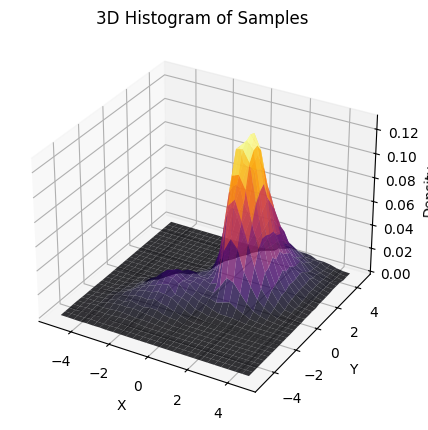

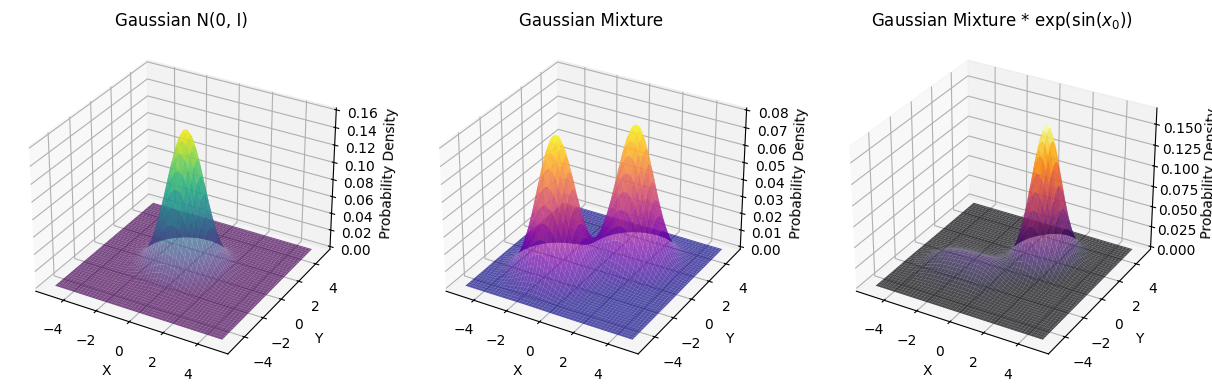

In [ ]:
plot_final_distribution(model_ft, include_reward=True)